In [1]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
import os
import torch.nn.functional as F
from tqdm import tqdm

In [2]:
import torch.nn as nn

In [3]:
from PIL import Image

In [39]:
!unzip city_images_v3.zip

Archive:  city_images_v3.zip
replace city_images_v3/img1088.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [4]:
# load in addresses of each park 
addresses_df = pd.read_csv('nyc_parks_bboxes_cehi.csv')
addresses_df = addresses_df.dropna(subset=['cehi'])
img_v2_dataset = []
for filename in tqdm(os.listdir('city_images_v3')):
    if filename[:2] == 'im':
        img = np.asarray(Image.open('city_images_v3/' + filename).convert('RGB'))
        img = np.transpose(img, (2, 0, 1))
        img_v2_dataset.append(img)
# get 256 x 256
img_256_dataset = []
for i in range(len(img_v2_dataset)):
    try:
        img = img_v2_dataset[i].copy()
        center_x = len(img[0])//2
        center_y = len(img[0][0])//2
        img = img[:, center_x - 128:center_x + 128, center_y-128:center_y + 128]
        #print(img.shape)
        assert(img.shape[1] == 256 and img.shape[2] == 256)
        img_256_dataset.append((img, i))
    except:
        continue
img_128_dataset = []
for i in range(len(img_v2_dataset)):
    try:
        img = img_v2_dataset[i].copy()
        center_x = len(img[0])//2
        center_y = len(img[0][0])//2
        img = img[:, center_x - 64:center_x + 64, center_y-64:center_y + 64]
        assert(img.shape[1] == 128 and img.shape[2] == 128)
        img_128_dataset.append((img, i))
    except:
        continue

100%|██████████| 1670/1670 [00:09<00:00, 182.47it/s]


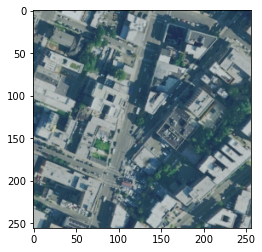

In [5]:
plt.imshow(np.transpose(img_256_dataset[0][0], (1, 2, 0)))

In [49]:
import torchvision
transform = torchvision.transforms.GaussianBlur()
plt.imshow(transform(torch.from_numpy(np.transpose(img_128_dataset[0][0], (1, 2, 0)))))

TypeError: __init__() missing 1 required positional argument: 'kernel_size'

In [6]:
img_256_images = [p[0] for p in img_256_dataset]

In [7]:
img_256_split = []
for i in tqdm(range(len(img_256_images))):
    img = img_256_images[i]
    l = []
    #print(img.shape)
    for i in range(4):
        for j in range(4):
            l.append(img[:, i*64:(i + 1)*64, j*64:(j + 1)*64])
    img_256_split.extend(l)
#     print(img_256_split[0])
#     print("MORE")
#     print(img_256_images[0][:, 0:64, 0:64])
#     assert False
img_256_images = torch.tensor(img_256_images)
img_256_split = torch.tensor(img_256_split)
img_256_split = img_256_split/255.

100%|██████████| 1519/1519 [00:00<00:00, 74315.57it/s]
/tmp/user/22282/ipykernel_2443326/3042172849.py:14: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1656352660876/work/torch/csrc/utils/tensor_new.cpp:201.)
  img_256_images = torch.tensor(img_256_images)


In [ ]:
class AE(nn.Module):
    
    def __init__(self):
        super(AE, self).__init__()
        self.lin1 = nn.Linear(3*64*64, 512)
        self.lin2 = nn.Linear(512, 256)
        self.lin3 = nn.Linear(256, 512)
        self.lin4 = nn.Linear(512, 3*64*64)
        
    def encode(self, x):
        x = torch.flatten(x, start_dim = 1)
        x = F.relu(self.lin1(x))
        x = F.relu(self.lin2(x))
        return F.sigmoid(x)
    
    def decode(self, x):
        x = F.relu(self.lin3(x))
        return F.sigmoid(self.lin4(x))
    
    def forward(self, x):
        return self.decode(self.encode(x))
    

In [22]:
class ConvAE(nn.Module):

    def __init__(self):
        super(ConvAE, self).__init__()
        self.conv1 = nn.Conv2d(3, 8, 3, stride=2, padding = 1)
        self.conv2 = nn.Conv2d(8, 16, 3, stride=2, padding = 1)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv3 = nn.Conv2d(16, 32, 3, stride=2)
        self.flatten = nn.Flatten(start_dim=1)
        self.elin1 = nn.Linear(1568, 1024)
        self.elin2 = nn.Linear(1024, 1024)
        self.elin3 = nn.Linear(1024,128)

        
        self.dlin1 = nn.Linear(128, 1024)
        self.dlin2 = nn.Linear(1024, 1024)
        self.dlin3 = nn.Linear(1024, 1568)
        self.unflatten = nn.Unflatten(dim = 1, unflattened_size = (32, 7, 7))
        self.deconv1 = nn.ConvTranspose2d(32, 16, 3, stride=2, output_padding=0)
        self.dbn1 = nn.BatchNorm2d(16)
        self.deconv2 = nn.ConvTranspose2d(16, 8, 3, stride=2, padding=0, output_padding=1)
        self.dbn2 = nn.BatchNorm2d(8)
        self.deconv3 = nn.ConvTranspose2d(8, 3, 3, stride=2, padding=1, output_padding=1)
        self.sigm = nn.Sigmoid()
        
    def encode(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.bn1(self.conv2(x)))
        x = F.relu(self.flatten(self.conv3(x)))
        x = F.relu(self.elin1(x))
        x = F.relu(self.elin2(x))
        return self.elin3(x)
    
    def decode(self, x):
        x = F.relu(self.dlin1(x))
        x = F.relu(self.dlin2(x))
        x = F.relu(self.dlin3(x))
        x = F.relu(self.dbn1(self.deconv1(self.unflatten(x))))
        x = F.relu(self.dbn2(self.deconv2(x)))
        return self.deconv3(x)
    
    def forward(self, x):
        return  self.sigm(self.decode(self.encode(x)))
        

In [23]:
dataset_split = torch.utils.data.TensorDataset(img_256_split, torch.zeros((len(img_256_split), 1)))
dataloader_split = torch.utils.data.DataLoader(dataset_split, batch_size=64,shuffle=True)

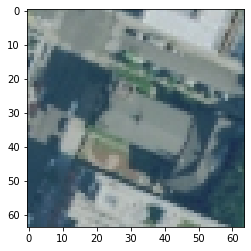

In [10]:
plt.imshow(np.transpose(img_256_split[0].clone().detach().numpy(), (1, 2, 0)))
# working for now

In [11]:
#initialize parameters
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform(m.weight)
        m.bias.data.fill_(0.01)
    if isinstance(m, nn.Conv2d):
        torch.nn.init.xavier_uniform(m.weight)
        m.bias.data.fill_(0.01)


In [ ]:
def device_as(t1, t2):
   """
   Moves t1 to the device of t2
   """
   return t1.to(t2.device)

class ContrastiveLoss(nn.Module):
   """
   Vanilla Contrastive loss, also called InfoNceLoss as in SimCLR paper
   """
   def __init__(self, batch_size, temperature=0.5):
       super().__init__()
       self.batch_size = batch_size
       self.temperature = temperature
       self.mask = (~torch.eye(batch_size * 2, batch_size * 2, dtype=bool)).float()

   def calc_similarity_batch(self, a, b):
       representations = torch.cat([a, b], dim=0)
       return F.cosine_similarity(representations.unsqueeze(1), representations.unsqueeze(0), dim=2)

   def forward(self, proj_1, proj_2):
       """
       proj_1 and proj_2 are batched embeddings [batch, embedding_dim]
       where corresponding indices are pairs
       z_i, z_j in the SimCLR paper
       """
       batch_size = proj_1.shape[0]
       z_i = F.normalize(proj_1, p=2, dim=1)
       z_j = F.normalize(proj_2, p=2, dim=1)

       similarity_matrix = self.calc_similarity_batch(z_i, z_j)

       sim_ij = torch.diag(similarity_matrix, batch_size)
       sim_ji = torch.diag(similarity_matrix, -batch_size)

       positives = torch.cat([sim_ij, sim_ji], dim=0)

       nominator = torch.exp(positives / self.temperature)

       denominator = device_as(self.mask, similarity_matrix) * torch.exp(similarity_matrix / self.temperature)

       all_losses = -torch.log(nominator / torch.sum(denominator, dim=1))
       loss = torch.sum(all_losses) / (2 * self.batch_size)
       return loss

In [ ]:
import torchvision.transforms as T

class Augment:
   """
   A stochastic data augmentation module
   Transforms any given data example randomly
   resulting in two correlated views of the same example,
   denoted x ̃i and x ̃j, which we consider as a positive pair.
   """

   def __init__(self, img_size, s=1):
       color_jitter = T.ColorJitter(
           0.8 * s, 0.8 * s, 0.8 * s, 0.2 * s
       )
       # 10% of the image
       blur = T.GaussianBlur((3, 3), (0.1, 2.0))

       self.train_transform = torch.nn.Sequential(
           T.RandomResizedCrop(size=img_size),
           T.RandomHorizontalFlip(p=0.5),  # with 0.5 probability
           T.RandomApply([color_jitter], p=0.8),
           T.RandomApply([blur], p=0.5),
           T.RandomGrayscale(p=0.2),
           # imagenet stats
           T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
       )

   def __call__(self, x):
       return self.train_transform(x), self.train_transform(x)

In [29]:
ae = ConvAE()
device = 'cuda:1' if torch.cuda.is_available() else 'cpu'
ae.apply(init_weights)
ae.to(device)
optimizer = torch.optim.AdamW(ae.parameters(), lr=1e-3,amsgrad=False)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,patience=2)
loss_data = []
for epoch in range(120):
    criterion = torch.nn.MSELoss()    # criterion = torch.nn.KLDivLoss()
    running_loss = 0
    for (i, data) in tqdm(enumerate(dataloader_split)):
        # data.to(device)
        images, _ = data
        images = images.to(device)
        output = ae(images)
        output = output.to(device)
        loss = criterion(output, images)

        running_loss += loss.item()
        loss.backward()
        optimizer.step() 
        optimizer.zero_grad()
    scheduler.step(running_loss)
    # print loss at end 
#     running_loss = 0
#     with torch.no_grad():
#         for (i, data) in tqdm(enumerate(dataloader_split)):
#             images, _ = data
#             loss = criterion(ae(images), torch.flatten(images, start_dim=1))
#             running_loss += loss.item()   
    loss_data.append(running_loss)
    print(f"Running loss at epoch {epoch}: {running_loss}")

/tmp/user/22282/ipykernel_2443326/2930908865.py:7: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(m.weight)
/tmp/user/22282/ipykernel_2443326/2930908865.py:4: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(m.weight)
380it [00:05, 72.08it/s]
9it [00:00, 81.76it/s]

Running loss at epoch 0: 8.138064417988062


380it [00:05, 72.02it/s]
8it [00:00, 74.28it/s]

Running loss at epoch 1: 6.640339323319495


380it [00:04, 79.49it/s]
9it [00:00, 84.50it/s]

Running loss at epoch 2: 6.362983865663409


380it [00:05, 74.99it/s]
8it [00:00, 72.25it/s]

Running loss at epoch 3: 5.948171283118427


380it [00:05, 69.70it/s]
8it [00:00, 75.98it/s]

Running loss at epoch 4: 5.5957768792286515


380it [00:05, 72.35it/s]
7it [00:00, 65.38it/s]

Running loss at epoch 5: 5.396800208836794


380it [00:05, 70.79it/s]
7it [00:00, 68.22it/s]

Running loss at epoch 6: 5.288770988583565


380it [00:05, 70.97it/s]
7it [00:00, 67.83it/s]

Running loss at epoch 7: 5.08924869261682


380it [00:05, 71.36it/s]
8it [00:00, 74.99it/s]

Running loss at epoch 8: 5.053482879884541


380it [00:05, 70.41it/s]
8it [00:00, 73.86it/s]

Running loss at epoch 9: 5.020475350320339


380it [00:05, 72.45it/s]
9it [00:00, 87.94it/s]

Running loss at epoch 10: 4.950658223591745


380it [00:05, 71.96it/s]
9it [00:00, 86.51it/s]

Running loss at epoch 11: 4.836134194396436


380it [00:05, 70.78it/s]
7it [00:00, 67.64it/s]

Running loss at epoch 12: 4.762357006780803


380it [00:05, 71.49it/s]
7it [00:00, 66.68it/s]

Running loss at epoch 13: 4.708081986755133


380it [00:05, 70.20it/s]
8it [00:00, 76.40it/s]

Running loss at epoch 14: 4.600314745679498


380it [00:05, 71.37it/s]
7it [00:00, 66.53it/s]

Running loss at epoch 15: 4.519576947204769


380it [00:05, 72.78it/s]
9it [00:00, 80.12it/s]

Running loss at epoch 16: 4.452623074874282


380it [00:04, 76.89it/s]
8it [00:00, 77.54it/s]

Running loss at epoch 17: 4.39833468478173


380it [00:04, 80.15it/s]
9it [00:00, 82.77it/s]

Running loss at epoch 18: 4.373495831154287


380it [00:05, 73.09it/s]
8it [00:00, 77.16it/s]

Running loss at epoch 19: 4.349342726171017


380it [00:05, 74.13it/s]
7it [00:00, 64.51it/s]

Running loss at epoch 20: 4.292979602701962


380it [00:05, 74.09it/s]
8it [00:00, 74.14it/s]

Running loss at epoch 21: 4.237289293669164


380it [00:05, 72.36it/s]
7it [00:00, 67.49it/s]

Running loss at epoch 22: 4.181370919570327


380it [00:05, 71.28it/s]
9it [00:00, 89.41it/s]

Running loss at epoch 23: 4.135066377930343


380it [00:05, 73.86it/s]
7it [00:00, 68.71it/s]

Running loss at epoch 24: 4.0914958249777555


380it [00:05, 70.65it/s]
8it [00:00, 69.18it/s]

Running loss at epoch 25: 4.078546615317464


380it [00:05, 72.08it/s]
8it [00:00, 77.60it/s]

Running loss at epoch 26: 4.055138207040727


380it [00:05, 71.80it/s]
7it [00:00, 63.01it/s]

Running loss at epoch 27: 4.002434741705656


380it [00:05, 68.92it/s]
7it [00:00, 64.70it/s]

Running loss at epoch 28: 3.9559864019975066


380it [00:05, 71.02it/s]
8it [00:00, 75.42it/s]

Running loss at epoch 29: 3.9360950412228703


380it [00:05, 71.64it/s]
8it [00:00, 71.62it/s]

Running loss at epoch 30: 3.896244475618005


380it [00:05, 70.86it/s]
7it [00:00, 63.82it/s]

Running loss at epoch 31: 3.8703992031514645


380it [00:05, 70.85it/s]
8it [00:00, 77.67it/s]

Running loss at epoch 32: 3.8147240951657295


380it [00:04, 76.60it/s]
7it [00:00, 67.04it/s]

Running loss at epoch 33: 3.7707108687609434


380it [00:05, 73.73it/s]
8it [00:00, 74.49it/s]

Running loss at epoch 34: 3.7417652755975723


380it [00:05, 70.34it/s]
7it [00:00, 63.79it/s]

Running loss at epoch 35: 3.730398705229163


380it [00:05, 70.17it/s]
8it [00:00, 71.50it/s]

Running loss at epoch 36: 3.7023192374035716


380it [00:05, 71.13it/s]
7it [00:00, 68.66it/s]

Running loss at epoch 37: 3.67583245318383


380it [00:05, 71.15it/s]
7it [00:00, 67.22it/s]

Running loss at epoch 38: 3.6382898036390543


380it [00:04, 76.94it/s]
8it [00:00, 73.09it/s]

Running loss at epoch 39: 3.623534368351102


380it [00:05, 70.95it/s]
8it [00:00, 73.13it/s]

Running loss at epoch 40: 3.589746693149209


380it [00:05, 71.18it/s]
7it [00:00, 64.11it/s]

Running loss at epoch 41: 3.563475483097136


380it [00:05, 71.57it/s]
8it [00:00, 78.63it/s]

Running loss at epoch 42: 3.534959914162755


380it [00:05, 72.10it/s]
7it [00:00, 65.02it/s]

Running loss at epoch 43: 3.514630992896855


380it [00:04, 76.81it/s]
8it [00:00, 79.96it/s]

Running loss at epoch 44: 3.4936267556622624


380it [00:05, 75.30it/s]
8it [00:00, 75.52it/s]

Running loss at epoch 45: 3.4739016937091947


380it [00:05, 73.39it/s]
11it [00:00, 105.57it/s]

Running loss at epoch 46: 3.4506299421191216


380it [00:05, 74.05it/s]
8it [00:00, 71.46it/s]

Running loss at epoch 47: 3.434840033762157


380it [00:05, 74.97it/s]
7it [00:00, 65.91it/s]

Running loss at epoch 48: 3.4060502694919705


380it [00:05, 72.26it/s]
8it [00:00, 74.57it/s]

Running loss at epoch 49: 3.379999736789614


380it [00:05, 74.67it/s]
9it [00:00, 80.34it/s]

Running loss at epoch 50: 3.36091234581545


380it [00:04, 79.91it/s]
10it [00:00, 90.49it/s]

Running loss at epoch 51: 3.338927107863128


380it [00:05, 73.81it/s]
7it [00:00, 67.79it/s]

Running loss at epoch 52: 3.3286416810005903


380it [00:05, 72.27it/s]
8it [00:00, 78.90it/s]

Running loss at epoch 53: 3.305263059679419


380it [00:05, 73.42it/s]
8it [00:00, 71.03it/s]

Running loss at epoch 54: 3.3024445744231343


380it [00:05, 74.52it/s]
8it [00:00, 79.49it/s]

Running loss at epoch 55: 3.2685876972973347


380it [00:05, 74.37it/s]
8it [00:00, 71.52it/s]

Running loss at epoch 56: 3.2651940882205963


380it [00:05, 68.60it/s]
7it [00:00, 63.52it/s]

Running loss at epoch 57: 3.257458837237209


380it [00:05, 74.80it/s]
7it [00:00, 68.32it/s]

Running loss at epoch 58: 3.226377765648067


380it [00:05, 72.06it/s]
9it [00:00, 87.39it/s]

Running loss at epoch 59: 3.2211136664263904


380it [00:05, 74.56it/s]
7it [00:00, 66.97it/s]

Running loss at epoch 60: 3.201383092906326


380it [00:05, 74.94it/s]
8it [00:00, 77.44it/s]

Running loss at epoch 61: 3.1885040728375316


380it [00:05, 70.57it/s]
8it [00:00, 73.06it/s]

Running loss at epoch 62: 3.178323677740991


380it [00:05, 70.41it/s]
8it [00:00, 78.18it/s]

Running loss at epoch 63: 3.158858384937048


380it [00:05, 69.23it/s]
7it [00:00, 67.18it/s]

Running loss at epoch 64: 3.1513727055862546


380it [00:05, 71.22it/s]
8it [00:00, 70.27it/s]

Running loss at epoch 65: 3.1381149445660412


380it [00:05, 68.30it/s]
7it [00:00, 65.62it/s]

Running loss at epoch 66: 3.1192136891186237


380it [00:05, 74.24it/s]
8it [00:00, 78.77it/s]

Running loss at epoch 67: 3.1085463212803006


380it [00:05, 72.73it/s]
7it [00:00, 65.47it/s]

Running loss at epoch 68: 3.1054112100973725


380it [00:05, 70.70it/s]
8it [00:00, 71.12it/s]

Running loss at epoch 69: 3.089694512076676


380it [00:05, 71.33it/s]
10it [00:00, 96.23it/s]

Running loss at epoch 70: 3.0849978197366


380it [00:05, 72.03it/s]
7it [00:00, 68.36it/s]

Running loss at epoch 71: 3.0664606783539057


380it [00:05, 70.48it/s]
7it [00:00, 67.67it/s]

Running loss at epoch 72: 3.060968780890107


380it [00:05, 70.32it/s]
8it [00:00, 74.15it/s]

Running loss at epoch 73: 3.0478681758977473


380it [00:05, 70.23it/s]
9it [00:00, 85.53it/s]

Running loss at epoch 74: 3.032399225514382


380it [00:04, 76.90it/s]
7it [00:00, 65.75it/s]

Running loss at epoch 75: 3.026240929029882


380it [00:05, 74.68it/s]
8it [00:00, 71.22it/s]

Running loss at epoch 76: 3.01611538650468


380it [00:05, 73.03it/s]
7it [00:00, 69.81it/s]

Running loss at epoch 77: 3.008248681668192


380it [00:05, 74.44it/s]
7it [00:00, 67.79it/s]

Running loss at epoch 78: 3.001455021556467


380it [00:05, 71.43it/s]
7it [00:00, 62.07it/s]

Running loss at epoch 79: 2.9857111275196075


380it [00:05, 70.79it/s]
8it [00:00, 76.13it/s]

Running loss at epoch 80: 2.985755017027259


380it [00:05, 71.38it/s]
9it [00:00, 79.79it/s]

Running loss at epoch 81: 2.972896928433329


380it [00:05, 69.88it/s]
8it [00:00, 76.39it/s]

Running loss at epoch 82: 2.9557037260383368


380it [00:05, 71.48it/s]
8it [00:00, 74.57it/s]

Running loss at epoch 83: 2.955980614759028


380it [00:05, 73.58it/s]
7it [00:00, 66.81it/s]

Running loss at epoch 84: 2.9478495554067194


380it [00:04, 86.14it/s]
10it [00:00, 96.14it/s]

Running loss at epoch 85: 2.9386980989947915


380it [00:04, 77.47it/s]
7it [00:00, 62.05it/s]

Running loss at epoch 86: 2.936185530386865


380it [00:05, 68.69it/s]
7it [00:00, 69.17it/s]

Running loss at epoch 87: 2.9180570687167346


380it [00:05, 71.21it/s]
8it [00:00, 75.67it/s]

Running loss at epoch 88: 2.912054061423987


380it [00:05, 69.97it/s]
8it [00:00, 75.31it/s]

Running loss at epoch 89: 2.9100185986608267


380it [00:05, 73.13it/s]
8it [00:00, 79.01it/s]

Running loss at epoch 90: 2.9020431004464626


380it [00:05, 72.75it/s]
8it [00:00, 72.60it/s]

Running loss at epoch 91: 2.891446546651423


380it [00:05, 71.23it/s]
7it [00:00, 64.17it/s]

Running loss at epoch 92: 2.88502443395555


380it [00:05, 71.84it/s]
8it [00:00, 70.25it/s]

Running loss at epoch 93: 2.8758786409161985


380it [00:05, 70.56it/s]
7it [00:00, 65.72it/s]

Running loss at epoch 94: 2.8695940827019513


380it [00:05, 70.25it/s]
8it [00:00, 74.32it/s]

Running loss at epoch 95: 2.8674809648655355


380it [00:05, 72.33it/s]
7it [00:00, 69.80it/s]

Running loss at epoch 96: 2.8571579847484827


380it [00:05, 70.52it/s]
7it [00:00, 65.53it/s]

Running loss at epoch 97: 2.8484270935878158


380it [00:05, 71.11it/s]
8it [00:00, 70.89it/s]

Running loss at epoch 98: 2.849666146095842


380it [00:05, 71.41it/s]
7it [00:00, 68.67it/s]

Running loss at epoch 99: 2.8407023828476667


380it [00:05, 75.63it/s]
7it [00:00, 69.71it/s]

Running loss at epoch 100: 2.8322787415236235


380it [00:05, 70.38it/s]
7it [00:00, 66.78it/s]

Running loss at epoch 101: 2.8231637170538306


380it [00:05, 71.50it/s]
9it [00:00, 82.68it/s]

Running loss at epoch 102: 2.818027392961085


380it [00:05, 71.66it/s]
10it [00:00, 90.04it/s]

Running loss at epoch 103: 2.808913202956319


380it [00:04, 76.62it/s]
8it [00:00, 73.57it/s]

Running loss at epoch 104: 2.810903873760253


380it [00:05, 72.79it/s]
7it [00:00, 69.35it/s]

Running loss at epoch 105: 2.8043558727949858


380it [00:05, 71.62it/s]
8it [00:00, 75.18it/s]

Running loss at epoch 106: 2.796833523083478


380it [00:05, 75.47it/s]
7it [00:00, 64.23it/s]

Running loss at epoch 107: 2.7934297621250153


380it [00:05, 71.72it/s]
7it [00:00, 64.79it/s]

Running loss at epoch 108: 2.789272369351238


380it [00:05, 70.77it/s]
8it [00:00, 75.96it/s]

Running loss at epoch 109: 2.783102732617408


380it [00:05, 70.11it/s]
7it [00:00, 67.60it/s]

Running loss at epoch 110: 2.7777236378751695


380it [00:05, 71.39it/s]
8it [00:00, 74.06it/s]

Running loss at epoch 111: 2.777741114143282


380it [00:05, 71.97it/s]
8it [00:00, 78.68it/s]

Running loss at epoch 112: 2.767479928676039


380it [00:05, 71.10it/s]
9it [00:00, 83.04it/s]

Running loss at epoch 113: 2.7597080217674375


380it [00:05, 70.04it/s]
8it [00:00, 72.25it/s]

Running loss at epoch 114: 2.756307736504823


380it [00:05, 75.22it/s]
9it [00:00, 88.55it/s]

Running loss at epoch 115: 2.7525165951810777


380it [00:04, 78.10it/s]
10it [00:00, 95.08it/s]

Running loss at epoch 116: 2.7458393364213407


380it [00:04, 83.81it/s]
8it [00:00, 70.75it/s]

Running loss at epoch 117: 2.742185584269464


380it [00:04, 80.83it/s]
7it [00:00, 66.46it/s]

Running loss at epoch 118: 2.738656422123313


380it [00:04, 79.79it/s]

Running loss at epoch 119: 2.7338133021257818


<function matplotlib.pyplot.show(close=None, block=None)>

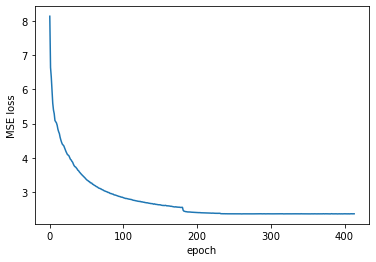

In [42]:
plt.plot(loss_data)
plt.xlabel("epoch")
plt.ylabel("MSE loss")
plt.show

In [40]:
ae.to(device)
for epoch in range(120):
    criterion = torch.nn.MSELoss()    # criterion = torch.nn.KLDivLoss()
    running_loss = 0
    for (i, data) in tqdm(enumerate(dataloader_split)):
        # data.to(device)
        images, _ = data
        images = images.to(device)
        output = ae(images)
        output = output.to(device)
        loss = criterion(output, images)

        running_loss += loss.item()
        loss.backward()
        optimizer.step() 
        optimizer.zero_grad()
    scheduler.step(running_loss)
    # print loss at end 
#     running_loss = 0
#     with torch.no_grad():
#         for (i, data) in tqdm(enumerate(dataloader_split)):
#             images, _ = data
#             loss = criterion(ae(images), torch.flatten(images, start_dim=1))
#             running_loss += loss.item()   
    loss_data.append(running_loss)
    print(f"Running loss at epoch {epoch}: {running_loss}")
    print(optimizer.param_groups[0]['lr'])

380it [00:04, 82.26it/s]
9it [00:00, 88.26it/s]

Running loss at epoch 0: 2.3620063844136894
1.0000000000000004e-08


380it [00:05, 75.48it/s]
7it [00:00, 69.72it/s]

Running loss at epoch 1: 2.3608570666983724
1.0000000000000004e-08


380it [00:04, 80.17it/s]
8it [00:00, 74.45it/s]

Running loss at epoch 2: 2.3625566074624658
1.0000000000000004e-08


380it [00:04, 77.97it/s]
8it [00:00, 72.75it/s]

Running loss at epoch 3: 2.3613123623654246
1.0000000000000004e-08


380it [00:04, 77.54it/s]
9it [00:00, 81.93it/s]

Running loss at epoch 4: 2.3616136461496353
1.0000000000000004e-08


380it [00:04, 83.39it/s]
8it [00:00, 72.65it/s]

Running loss at epoch 5: 2.362091544549912
1.0000000000000004e-08


380it [00:05, 75.47it/s]
9it [00:00, 83.98it/s]

Running loss at epoch 6: 2.3610591352917254
1.0000000000000004e-08


380it [00:05, 73.10it/s]
10it [00:00, 90.15it/s]

Running loss at epoch 7: 2.3604979403316975
1.0000000000000004e-08


380it [00:04, 80.60it/s]
7it [00:00, 64.23it/s]

Running loss at epoch 8: 2.3610918512567878
1.0000000000000004e-08


380it [00:04, 79.85it/s]
8it [00:00, 71.53it/s]

Running loss at epoch 9: 2.359780116006732
1.0000000000000004e-08


380it [00:04, 85.43it/s]
7it [00:00, 65.76it/s]

Running loss at epoch 10: 2.3612789353355765
1.0000000000000004e-08


380it [00:04, 83.24it/s]
8it [00:00, 72.92it/s]

Running loss at epoch 11: 2.361467389855534
1.0000000000000004e-08


380it [00:04, 80.69it/s]
10it [00:00, 96.78it/s]

Running loss at epoch 12: 2.36057722941041
1.0000000000000004e-08


380it [00:04, 81.69it/s]
8it [00:00, 76.97it/s]

Running loss at epoch 13: 2.3612666563130915
1.0000000000000004e-08


380it [00:04, 76.92it/s]
8it [00:00, 75.70it/s]

Running loss at epoch 14: 2.361259405966848
1.0000000000000004e-08


380it [00:04, 79.41it/s]
6it [00:00, 59.33it/s]

Running loss at epoch 15: 2.3618220263160765
1.0000000000000004e-08


380it [00:04, 80.58it/s]
8it [00:00, 78.52it/s]

Running loss at epoch 16: 2.3604496102780104
1.0000000000000004e-08


380it [00:04, 78.83it/s]
7it [00:00, 65.65it/s]

Running loss at epoch 17: 2.363065366167575
1.0000000000000004e-08


380it [00:04, 78.85it/s]
10it [00:00, 91.70it/s]

Running loss at epoch 18: 2.359666984062642
1.0000000000000004e-08


380it [00:04, 83.81it/s]
8it [00:00, 77.38it/s]

Running loss at epoch 19: 2.36242809984833
1.0000000000000004e-08


380it [00:04, 79.43it/s]
8it [00:00, 76.61it/s]

Running loss at epoch 20: 2.360473739914596
1.0000000000000004e-08


380it [00:04, 79.11it/s]
7it [00:00, 60.07it/s]

Running loss at epoch 21: 2.3618650771677494
1.0000000000000004e-08


380it [00:04, 79.39it/s]
7it [00:00, 69.42it/s]

Running loss at epoch 22: 2.362867843359709
1.0000000000000004e-08


380it [00:04, 80.01it/s]
8it [00:00, 77.64it/s]

Running loss at epoch 23: 2.3599239108152688
1.0000000000000004e-08


380it [00:04, 77.47it/s]
8it [00:00, 72.01it/s]

Running loss at epoch 24: 2.3608707902021706
1.0000000000000004e-08


380it [00:04, 76.84it/s]
8it [00:00, 76.35it/s]

Running loss at epoch 25: 2.3626376567408442
1.0000000000000004e-08


380it [00:04, 78.85it/s]
10it [00:00, 93.61it/s]

Running loss at epoch 26: 2.3614121885038912
1.0000000000000004e-08


380it [00:04, 77.82it/s]
9it [00:00, 89.14it/s]

Running loss at epoch 27: 2.361566588282585
1.0000000000000004e-08


380it [00:04, 79.17it/s]
8it [00:00, 78.33it/s]

Running loss at epoch 28: 2.3611603141762316
1.0000000000000004e-08


380it [00:04, 79.17it/s]
8it [00:00, 76.81it/s]

Running loss at epoch 29: 2.3609463116154075
1.0000000000000004e-08


380it [00:04, 78.50it/s]
9it [00:00, 79.65it/s]

Running loss at epoch 30: 2.362267587799579
1.0000000000000004e-08


380it [00:04, 76.60it/s]
8it [00:00, 73.00it/s]

Running loss at epoch 31: 2.361399236600846
1.0000000000000004e-08


380it [00:04, 76.13it/s]
6it [00:00, 57.00it/s]

Running loss at epoch 32: 2.3608167115598917
1.0000000000000004e-08


380it [00:05, 70.48it/s]
9it [00:00, 83.31it/s]

Running loss at epoch 33: 2.3600551914423704
1.0000000000000004e-08


380it [00:04, 78.01it/s]
10it [00:00, 94.59it/s]

Running loss at epoch 34: 2.3611485953442752
1.0000000000000004e-08


380it [00:04, 81.16it/s]
10it [00:00, 91.35it/s]

Running loss at epoch 35: 2.361753753852099
1.0000000000000004e-08


380it [00:04, 84.69it/s]
11it [00:00, 104.54it/s]

Running loss at epoch 36: 2.362333214841783
1.0000000000000004e-08


380it [00:04, 82.86it/s]
8it [00:00, 74.35it/s]

Running loss at epoch 37: 2.36031294753775
1.0000000000000004e-08


380it [00:04, 84.02it/s]
10it [00:00, 92.16it/s]

Running loss at epoch 38: 2.360514038708061
1.0000000000000004e-08


380it [00:04, 84.32it/s]
10it [00:00, 94.19it/s]

Running loss at epoch 39: 2.362075717654079
1.0000000000000004e-08


380it [00:04, 86.37it/s]
10it [00:00, 92.27it/s]

Running loss at epoch 40: 2.36092383088544
1.0000000000000004e-08


380it [00:04, 81.68it/s]
9it [00:00, 84.94it/s]

Running loss at epoch 41: 2.361589530017227
1.0000000000000004e-08


380it [00:04, 86.32it/s]
10it [00:00, 91.93it/s]

Running loss at epoch 42: 2.3621973139233887
1.0000000000000004e-08


380it [00:04, 88.86it/s]
8it [00:00, 75.77it/s]

Running loss at epoch 43: 2.361645126249641
1.0000000000000004e-08


380it [00:04, 83.49it/s]
9it [00:00, 85.67it/s]

Running loss at epoch 44: 2.3614893327467144
1.0000000000000004e-08


380it [00:04, 76.66it/s]
7it [00:00, 62.33it/s]

Running loss at epoch 45: 2.3602068503387272
1.0000000000000004e-08


380it [00:04, 76.85it/s]
9it [00:00, 86.68it/s]

Running loss at epoch 46: 2.3606736790388823
1.0000000000000004e-08


380it [00:04, 78.21it/s]
7it [00:00, 65.97it/s]

Running loss at epoch 47: 2.36429882934317
1.0000000000000004e-08


380it [00:04, 81.98it/s]
8it [00:00, 78.88it/s]

Running loss at epoch 48: 2.361306276638061
1.0000000000000004e-08


380it [00:05, 75.88it/s]
8it [00:00, 79.05it/s]

Running loss at epoch 49: 2.361998020671308
1.0000000000000004e-08


380it [00:04, 78.55it/s]
8it [00:00, 73.11it/s]

Running loss at epoch 50: 2.361459285952151
1.0000000000000004e-08


380it [00:04, 77.81it/s]
8it [00:00, 70.67it/s]

Running loss at epoch 51: 2.360302049666643
1.0000000000000004e-08


380it [00:04, 82.78it/s]
7it [00:00, 61.36it/s]

Running loss at epoch 52: 2.361001192126423
1.0000000000000004e-08


380it [00:05, 74.20it/s]
8it [00:00, 74.96it/s]

Running loss at epoch 53: 2.3605575780384243
1.0000000000000004e-08


380it [00:04, 79.03it/s]
9it [00:00, 84.71it/s]

Running loss at epoch 54: 2.3595747868530452
1.0000000000000004e-08


380it [00:04, 78.16it/s]
9it [00:00, 81.20it/s]

Running loss at epoch 55: 2.361695979721844
1.0000000000000004e-08


380it [00:04, 81.54it/s]
9it [00:00, 85.57it/s]

Running loss at epoch 56: 2.3600494037382305
1.0000000000000004e-08


380it [00:04, 79.69it/s]
8it [00:00, 78.87it/s]

Running loss at epoch 57: 2.3613401907496154
1.0000000000000004e-08


380it [00:05, 72.57it/s]
8it [00:00, 74.48it/s]

Running loss at epoch 58: 2.361212675459683
1.0000000000000004e-08


380it [00:04, 76.79it/s]
8it [00:00, 70.94it/s]

Running loss at epoch 59: 2.359585525467992
1.0000000000000004e-08


380it [00:04, 81.97it/s]
9it [00:00, 84.62it/s]

Running loss at epoch 60: 2.3598403241485357
1.0000000000000004e-08


380it [00:04, 82.97it/s]
9it [00:00, 79.50it/s]

Running loss at epoch 61: 2.361959330737591
1.0000000000000004e-08


380it [00:04, 83.47it/s]
8it [00:00, 72.88it/s]

Running loss at epoch 62: 2.360110691282898
1.0000000000000004e-08


380it [00:04, 82.42it/s]
9it [00:00, 85.38it/s]

Running loss at epoch 63: 2.3619562541134655
1.0000000000000004e-08


380it [00:04, 77.05it/s]
9it [00:00, 86.95it/s]

Running loss at epoch 64: 2.360076664481312
1.0000000000000004e-08


380it [00:04, 80.19it/s]
8it [00:00, 79.98it/s]

Running loss at epoch 65: 2.3622295116074383
1.0000000000000004e-08


380it [00:04, 83.02it/s]
9it [00:00, 89.49it/s]

Running loss at epoch 66: 2.3608295507729053
1.0000000000000004e-08


380it [00:04, 79.03it/s]
9it [00:00, 81.61it/s]

Running loss at epoch 67: 2.3615619763731956
1.0000000000000004e-08


380it [00:04, 86.33it/s]
8it [00:00, 79.05it/s]

Running loss at epoch 68: 2.360736072063446
1.0000000000000004e-08


380it [00:04, 77.70it/s]
9it [00:00, 85.21it/s]

Running loss at epoch 69: 2.3595194895751774
1.0000000000000004e-08


380it [00:04, 77.77it/s]
10it [00:00, 91.86it/s]

Running loss at epoch 70: 2.3627071385271847
1.0000000000000004e-08


380it [00:05, 74.19it/s]
9it [00:00, 81.90it/s]

Running loss at epoch 71: 2.360265349969268
1.0000000000000004e-08


380it [00:05, 74.77it/s]
9it [00:00, 77.83it/s]

Running loss at epoch 72: 2.3612034237012267
1.0000000000000004e-08


380it [00:04, 80.27it/s]
8it [00:00, 76.50it/s]

Running loss at epoch 73: 2.3624372710473835
1.0000000000000004e-08


380it [00:04, 79.09it/s]
8it [00:00, 75.12it/s]

Running loss at epoch 74: 2.36124290432781
1.0000000000000004e-08


380it [00:04, 77.70it/s]
9it [00:00, 81.75it/s]

Running loss at epoch 75: 2.3596331384032965
1.0000000000000004e-08


380it [00:05, 69.36it/s]
7it [00:00, 62.09it/s]

Running loss at epoch 76: 2.3608651692047715
1.0000000000000004e-08


380it [00:04, 79.22it/s]
10it [00:00, 89.30it/s]

Running loss at epoch 77: 2.3635787894017994
1.0000000000000004e-08


380it [00:04, 80.75it/s]
8it [00:00, 73.33it/s]

Running loss at epoch 78: 2.361978440079838
1.0000000000000004e-08


380it [00:04, 77.51it/s]
9it [00:00, 85.12it/s]

Running loss at epoch 79: 2.3607846181839705
1.0000000000000004e-08


380it [00:04, 85.08it/s]
6it [00:00, 58.38it/s]

Running loss at epoch 80: 2.3627700647339225
1.0000000000000004e-08


380it [00:05, 73.68it/s]
8it [00:00, 79.27it/s]

Running loss at epoch 81: 2.3612568033859134
1.0000000000000004e-08


380it [00:04, 79.76it/s]
8it [00:00, 70.71it/s]

Running loss at epoch 82: 2.3620835160836577
1.0000000000000004e-08


380it [00:04, 81.63it/s]
7it [00:00, 60.84it/s]

Running loss at epoch 83: 2.361503512598574
1.0000000000000004e-08


380it [00:05, 75.96it/s]
9it [00:00, 84.98it/s]

Running loss at epoch 84: 2.3623776035383344
1.0000000000000004e-08


380it [00:04, 81.63it/s]
7it [00:00, 64.27it/s]

Running loss at epoch 85: 2.3591515999287367
1.0000000000000004e-08


380it [00:05, 75.40it/s]
6it [00:00, 58.16it/s]

Running loss at epoch 86: 2.3608170025981963
1.0000000000000004e-08


380it [00:04, 85.46it/s]
9it [00:00, 85.86it/s]

Running loss at epoch 87: 2.359616349916905
1.0000000000000004e-08


380it [00:04, 80.23it/s]
9it [00:00, 89.97it/s]

Running loss at epoch 88: 2.364994573406875
1.0000000000000004e-08


380it [00:04, 85.61it/s]
9it [00:00, 83.37it/s]

Running loss at epoch 89: 2.361720150336623
1.0000000000000004e-08


380it [00:04, 85.38it/s]
9it [00:00, 82.62it/s]

Running loss at epoch 90: 2.3605883712880313
1.0000000000000004e-08


380it [00:04, 81.71it/s]
8it [00:00, 73.16it/s]

Running loss at epoch 91: 2.3609867854975164
1.0000000000000004e-08


380it [00:04, 82.64it/s]
10it [00:00, 94.03it/s]

Running loss at epoch 92: 2.3624227554537356
1.0000000000000004e-08


380it [00:04, 78.83it/s]
9it [00:00, 82.89it/s]

Running loss at epoch 93: 2.360584415961057
1.0000000000000004e-08


380it [00:05, 73.24it/s]
9it [00:00, 83.09it/s]

Running loss at epoch 94: 2.3619469455443323
1.0000000000000004e-08


380it [00:04, 83.16it/s]
8it [00:00, 79.94it/s]

Running loss at epoch 95: 2.3618219676427543
1.0000000000000004e-08


380it [00:04, 81.40it/s]
9it [00:00, 87.18it/s]

Running loss at epoch 96: 2.3590798205696046
1.0000000000000004e-08


380it [00:04, 83.32it/s]
9it [00:00, 82.27it/s]

Running loss at epoch 97: 2.3602720638737082
1.0000000000000004e-08


380it [00:04, 85.03it/s]
8it [00:00, 74.66it/s]

Running loss at epoch 98: 2.361458576284349
1.0000000000000004e-08


380it [00:04, 79.99it/s]
8it [00:00, 75.18it/s]

Running loss at epoch 99: 2.3620026032440364
1.0000000000000004e-08


380it [00:04, 79.67it/s]
9it [00:00, 86.14it/s]

Running loss at epoch 100: 2.359594979789108
1.0000000000000004e-08


380it [00:04, 76.50it/s]
8it [00:00, 71.46it/s]

Running loss at epoch 101: 2.3610676457174122
1.0000000000000004e-08


380it [00:04, 79.53it/s]
9it [00:00, 80.54it/s]

Running loss at epoch 102: 2.3614391568116844
1.0000000000000004e-08


380it [00:04, 80.86it/s]
9it [00:00, 88.95it/s]

Running loss at epoch 103: 2.3595325322821736
1.0000000000000004e-08


380it [00:04, 80.66it/s]
8it [00:00, 72.13it/s]

Running loss at epoch 104: 2.3616500846110284
1.0000000000000004e-08


380it [00:04, 77.74it/s]
9it [00:00, 85.09it/s]

Running loss at epoch 105: 2.361316803842783
1.0000000000000004e-08


380it [00:05, 75.62it/s]
9it [00:00, 84.08it/s]

Running loss at epoch 106: 2.3626220640726388
1.0000000000000004e-08


380it [00:04, 83.34it/s]
9it [00:00, 84.75it/s]

Running loss at epoch 107: 2.361488944850862
1.0000000000000004e-08


380it [00:04, 79.54it/s]
8it [00:00, 73.69it/s]

Running loss at epoch 108: 2.3597997464239597
1.0000000000000004e-08


380it [00:05, 72.30it/s]
9it [00:00, 83.09it/s]

Running loss at epoch 109: 2.3612441746518016
1.0000000000000004e-08


380it [00:04, 77.53it/s]
7it [00:00, 64.78it/s]

Running loss at epoch 110: 2.3601690428331494
1.0000000000000004e-08


380it [00:04, 78.16it/s]
10it [00:00, 96.34it/s]

Running loss at epoch 111: 2.3627124461345375
1.0000000000000004e-08


380it [00:04, 79.42it/s]
10it [00:00, 91.79it/s]

Running loss at epoch 112: 2.3592919344082475
1.0000000000000004e-08


380it [00:04, 83.14it/s]
9it [00:00, 80.91it/s]

Running loss at epoch 113: 2.3608579360879958
1.0000000000000004e-08


380it [00:04, 82.49it/s]
9it [00:00, 83.66it/s]

Running loss at epoch 114: 2.361142641864717
1.0000000000000004e-08


380it [00:04, 79.56it/s]
7it [00:00, 68.36it/s]

Running loss at epoch 115: 2.363428878597915
1.0000000000000004e-08


380it [00:05, 75.29it/s]
7it [00:00, 63.58it/s]

Running loss at epoch 116: 2.361837777774781
1.0000000000000004e-08


380it [00:04, 77.00it/s]
9it [00:00, 85.97it/s]

Running loss at epoch 117: 2.361509303562343
1.0000000000000004e-08


380it [00:04, 80.67it/s]
9it [00:00, 88.28it/s]

Running loss at epoch 118: 2.362327618058771
1.0000000000000004e-08


380it [00:04, 80.67it/s]

Running loss at epoch 119: 2.362790062557906
1.0000000000000004e-08


[[[128 140 126]
  [124 138 125]
  [122 137 130]
  ...
  [104 115 107]
  [122 138 128]
  [117 134 128]]

 [[151 163 143]
  [133 144 128]
  [122 135 128]
  ...
  [ 78  88  80]
  [140 151 143]
  [120 135 132]]

 [[177 185 162]
  [175 182 164]
  [147 157 149]
  ...
  [112 117 113]
  [140 151 145]
  [132 148 147]]

 ...

 [[106 138 159]
  [ 82 113 133]
  [ 48  76  97]
  ...
  [ 46  81  87]
  [ 43  81  84]
  [ 49  89  88]]

 [[112 147 167]
  [ 53  86 105]
  [ 45  76  96]
  ...
  [ 41  75  84]
  [ 42  80  83]
  [ 49  91  87]]

 [[ 75 110 130]
  [ 44  77  96]
  [ 44  75  93]
  ...
  [ 39  77  80]
  [ 42  82  82]
  [ 51  94  87]]]
[[[ 99 119 120]
  [108 131 137]
  [ 86 114 126]
  ...
  [129 142 135]
  [129 140 136]
  [122 133 129]]

 [[119 138 142]
  [109 133 143]
  [ 76 108 123]
  ...
  [122 138 137]
  [118 132 133]
  [121 133 133]]

 [[117 137 144]
  [ 70  98 110]
  [ 68 101 120]
  ...
  [ 57  79  90]
  [ 65  85  94]
  [ 93 112 119]]

 ...

 [[ 55  98  89]
  [ 68 111 104]
  [ 41  79  80]
  ..

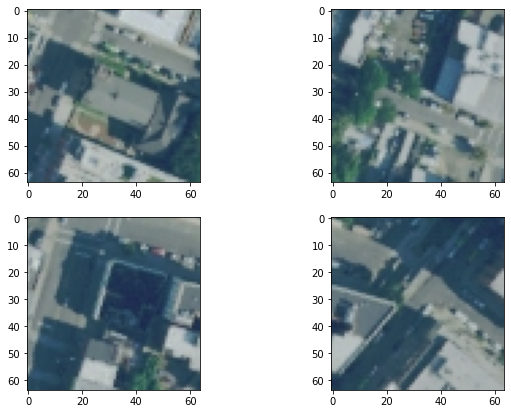

In [18]:
fig = plt.figure(figsize=(10, 7))
images = [img_256_split[i] for i in range(4)]
for i in range(4):
    images[i] = np.asarray(images[i])
    images[i] = (np.transpose(images[i], (1, 2, 0))*255).astype(int)
    print(images[i])
fig.add_subplot(2, 2, 1)
plt.imshow(images[0])
fig.add_subplot(2, 2, 2)
plt.imshow(images[1])
fig.add_subplot(2, 2, 3)
plt.imshow(images[2])
fig.add_subplot(2, 2, 4)
plt.imshow(images[3])

/tmp/user/22282/ipykernel_2443326/3631774529.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  images_n[i] = torch.tensor(images_n[i]).unsqueeze(0)


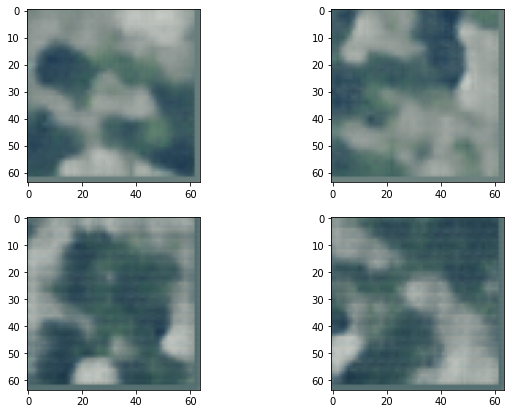

In [41]:
ae.to('cpu')
fig = plt.figure(figsize=(10, 7))
images_n = [img_256_split[i] for i in range(4)]
for i in range(4):
    with torch.no_grad():
        #images_n[i] = np.transpose(images_n[i], (2, 0, 1))
        images_n[i] = torch.tensor(images_n[i]).unsqueeze(0)
        #print(images_n[i].shape)
        images_n[i] = ae(images_n[i]).numpy()[0]
    #print(images_n[i].shape)
    images_n[i] = np.transpose(images_n[i], (1, 2, 0))
    #print(images_n[i].shape)
    images_n[i] = images_n[i]
fig.add_subplot(2, 2, 1)
plt.imshow(images_n[0])
fig.add_subplot(2, 2, 2)
plt.imshow(images_n[1])
fig.add_subplot(2, 2, 3)
plt.imshow(images_n[2])
fig.add_subplot(2, 2, 4)
plt.imshow(images_n[3])

In [ ]:
print(np.linalg.norm(images_n[i]/255. - images[i]/255.)**2)

2255.7130279267235


In [31]:
torch.save(ae.state_dict(),'04-states.pt')

In [ ]:
running_loss = 0
with torch.no_grad():
    for (i, data) in tqdm(enumerate(dataloader_split)):
        images, _ = data
        loss = criterion(ae(images), torch.flatten(images, start_dim=1))
        print(ae(images)[0])
        print(torch.flatten(images, start_dim=1)[0])
        assert False
        running_loss += loss.item()
print(running_loss)

0it [00:00, ?it/s]/project/ocean/junweih/miniconda3/envs/myenv/lib/python3.9/site-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([64, 12288])) that is different to the input size (torch.Size([64, 3, 64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



RuntimeError: The size of tensor a (64) must match the size of tensor b (12288) at non-singleton dimension 3